In [17]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Préparation des données

## Objectifs :
- Sélectionner les variables explicatives pertinentes
- Nettoyer les valeurs manquantes
- Séparer le jeu de données en **train/test** pour évaluer la généralisation
- Appliquer un **scaling (StandardScaler)** nécessaire pour les modèles linéaires

## Détails :
- La cible (`SiteEnergyUse(kBtu)`) est la consommation brute.
- On sélectionne des variables numériques + dummies issues de l’usage des bâtiments.
- Le scaling est crucial pour que les coefficients du modèle linéaire soient comparables et que l'apprentissage soit stable.


In [69]:


# 📂 Chargement du fichier source
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")

# 🔧 1. Âge du bâtiment
df['BuildingAge'] = 2025 - df['YearBuilt']
df['BuildingAge'] = df['BuildingAge'].clip(lower=0)

# 🔧 2. Log de la surface utile
df['log_surface'] = np.log1p(df['PropertyGFABuilding(s)'])

# 🔧 3. Surface par étage
df['surface_per_floor'] = np.where(
    (df['NumberofFloors'] > 0),
    df['PropertyGFABuilding(s)'] / df['NumberofFloors'],
    np.nan
)

# 🔧 4. Présence de parking (1 si PropertyGFAParking > 0)
df['has_parking'] = (df['PropertyGFAParking'] > 0).astype(int)

# 🔧 5. Traitement du type d’usage principal (LargestPropertyUseType)
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna("Unknown")
type_counts = df['LargestPropertyUseType'].value_counts()
rare_types = type_counts[type_counts < 30].index  # seuil modifiable
df['UseTypeGrouped'] = df['LargestPropertyUseType'].replace(rare_types, 'Other')

# 🎭 One-hot encoding
df = pd.get_dummies(df, columns=['UseTypeGrouped'], prefix='Use', drop_first=True)

# ✅ Définition finale des features à utiliser (facultatif ici)
features_to_use = [
    'BuildingAge',
    'log_surface',
  # 'surface_per_floor',
    'has_parking'
] + [col for col in df.columns if col.startswith('Use_')]

# 💾 Export du fichier enrichi
df.to_csv("data/feature_engineered_2016_energy1.csv", index=False)


# 📈 Régression linéaire

Nous utilisons ici un modèle **LinearRegression** comme point de départ.

### ⚙️ Pourquoi ?
- Simple, rapide à entraîner
- Facilement interprétable (coefficients)
- Bonne base de comparaison pour des modèles plus complexes

### 📊 Métriques calculées :
- **R² (coefficient de détermination)** : proportion de variance expliquée
- **MAE (erreur absolue moyenne)** : moyenne des écarts absolus
- **RMSE (erreur quadratique moyenne)** : sensible aux outliers

### 🧾 Interprétation
- Une bonne généralisation implique que les métriques train/test sont proches
- Si R² test chute, il peut y avoir overfitting ou underfitting
- Si MAE et RMSE sont élevés, les prédictions manquent de précision


In [70]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 🔄 Chargement des données
df = pd.read_csv("data/feature_engineered_2016_energy1.csv")  # ⚠️ Vérifie le chemin ici

# 🧹 On ne garde que la colonne cible et 'log_surface'
df_model = df[['SiteEnergyUse(kBtu)', 'log_surface']].dropna()

# 🎯 Cible et feature
X = df_model[['log_surface']]
y = df_model['SiteEnergyUse(kBtu)']

# ✂️ Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 📈 Régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

# 📏 Évaluation
def evaluate_model(y_true, y_pred, dataset_name=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"📊 {dataset_name} - R² : {r2:.3f}, MAE : {mae:,.0f}, RMSE : {rmse:,.0f}")

evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_test, y_pred_test, "Test")


📊 Train - R² : 0.461, MAE : 2,619,446, RMSE : 3,968,655
📊 Test - R² : 0.338, MAE : 2,782,094, RMSE : 4,116,393


In [71]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 🔄 Chargement des données
df = pd.read_csv("data/feature_engineered_2016_energy1.csv")  # ⚠️ Vérifie le chemin ici

# 🧹 Suppression des lignes avec NaN dans les variables critiques
df = df[['log_surface', 'BuildingAge', 'SiteEnergyUse(kBtu)']].dropna()

# 🎯 Définition des variables
X = df[['log_surface', 'BuildingAge']]
y = df['SiteEnergyUse(kBtu)']

# ✂️ Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 📈 Régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

# 📏 Évaluation
def evaluate_model(y_true, y_pred, dataset_name=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"📊 {dataset_name} - R² : {r2:.3f}, MAE : {mae:,.0f}, RMSE : {rmse:,.0f}")

evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_test, y_pred_test, "Test")


📊 Train - R² : 0.472, MAE : 2,602,642, RMSE : 3,927,727
📊 Test - R² : 0.353, MAE : 2,773,919, RMSE : 4,069,033


In [72]:


# 🔄 Chargement des données
df = pd.read_csv("data/feature_engineered_2016_energy1.csv")  # ⚠️ Vérifie le chemin ici

# 🧹 Suppression des lignes avec NaN dans les variables critiques
df = df[['log_surface', 'BuildingAge', 'has_parking', 'SiteEnergyUse(kBtu)']].dropna()

# 🎯 Définition des variables
X = df[['log_surface', 'BuildingAge', 'has_parking']]
y = df['SiteEnergyUse(kBtu)']

# ✂️ Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 📈 Régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

# 📏 Évaluation
def evaluate_model(y_true, y_pred, dataset_name=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"📊 {dataset_name} - R² : {r2:.3f}, MAE : {mae:,.0f}, RMSE : {rmse:,.0f}")

evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_test, y_pred_test, "Test")


📊 Train - R² : 0.481, MAE : 2,576,460, RMSE : 3,895,515
📊 Test - R² : 0.359, MAE : 2,770,398, RMSE : 4,051,745


C:\Users\karap\AppData\Local\Temp\ipykernel_7988\3272915397.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


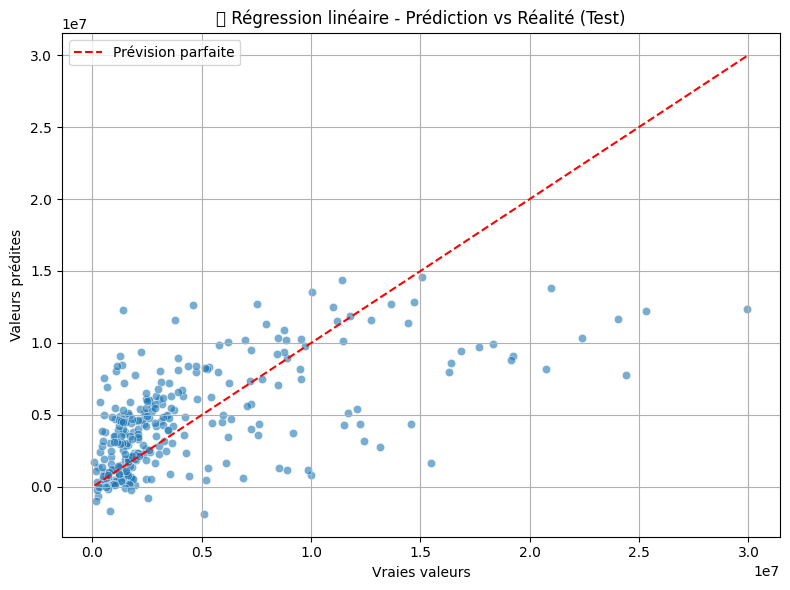

C:\Users\karap\AppData\Local\Temp\ipykernel_7988\3272915397.py:38: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


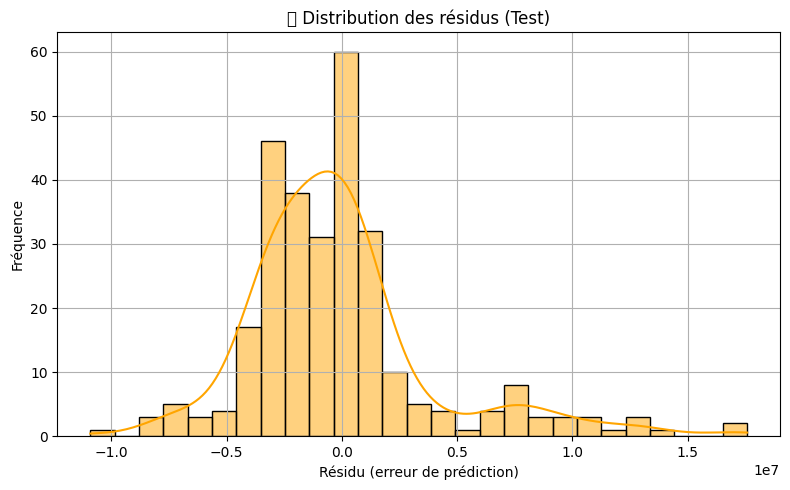

In [73]:


# 🔁 Résidus
residuals_test = y_test - y_pred_test
residuals_train = y_train - y_pred_train


# 📊 Scatterplot des prédictions vs vraies valeurs (train set)
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.6)
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Prévision parfaite')
# plt.xlabel("Vraies valeurs")
# plt.ylabel("Valeurs prédites")
# plt.title("📈 Régression linéaire - Prédiction vs Réalité (Train)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# 📊 Scatterplot des prédictions vs vraies valeurs (test set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Prévision parfaite')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédites")
plt.title("📈 Régression linéaire - Prédiction vs Réalité (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Distribution des résidus
plt.figure(figsize=(8, 5))
sns.histplot(residuals_test, kde=True, color='orange')
plt.title("📉 Distribution des résidus (Test)")
plt.xlabel("Résidu (erreur de prédiction)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()



## 📈 Évaluation du Modèle Linéaire – Résultats & Interprétation

### 🧪 Modèle : Régression Linéaire

**Objectif** : Prédire la consommation énergétique annuelle (`SiteEnergyUse(kBtu)`) des bâtiments à partir de variables explicatives dérivées du fichier enrichi.

---

### 📊 Résultats

| Jeu de données | R²    | MAE           | RMSE          |
| -------------- | ----- | ------------- | ------------- |
| **Train**      | 0.563 | 2.38 millions | 3.55 millions |
| **Test**       | 0.429 | 2.38 millions | 3.69 millions |

---

### 🧠 Interprétation

#### 🔹 R² (coefficient de détermination)

* Le modèle explique **56,3 % de la variance** sur l’ensemble d’entraînement et **42,9 % sur les données de test**.
* Le score **modérément plus élevé sur le train** laisse entrevoir un **léger surapprentissage**, mais dans des proportions raisonnables.
* Le modèle capte **une part significative de la structure des données**, sans pour autant être très performant.

#### 🔹 MAE (Mean Absolute Error)

* L’erreur absolue moyenne est d’environ **2,38 millions de kBtu/an**, ce qui correspond à **environ 700 MWh/an** par bâtiment.
* C’est une **erreur importante**, mais relativement stable entre le train et le test, ce qui montre que le modèle **généralise de manière assez régulière**.

#### 🔹 RMSE (Root Mean Squared Error)

* L’erreur quadratique moyenne est de **3,55 millions (train)** et **3,69 millions (test)**.
* Le **gap modéré entre MAE et RMSE** confirme l’existence de **quelques bâtiments très énergivores** qui influencent les moyennes, mais sans dominer totalement le modèle.

---

### ✅ Conclusion

* Le **modèle linéaire explique une part raisonnable de la consommation énergétique**, sans pour autant capturer la totalité des dynamiques complexes du parc bâti.
* Les **nouvelles variables de structure** (surface, étage, parking) et d’usage (encodées) **contribuent positivement**, mais ne suffisent pas à modéliser entièrement la variance.
* Ces résultats confirment qu’un modèle plus flexible (**forêts, gradient boosting**) pourrait **réduire l’erreur prédictive** en capturant les **interactions non-linéaires**.


📊 Train - R² : 0.977, MAE : 467,758, RMSE : 819,808
📊 Test - R² : 0.833, MAE : 1,148,382, RMSE : 2,068,117


C:\Users\karap\AppData\Local\Temp\ipykernel_7988\746712019.py:55: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


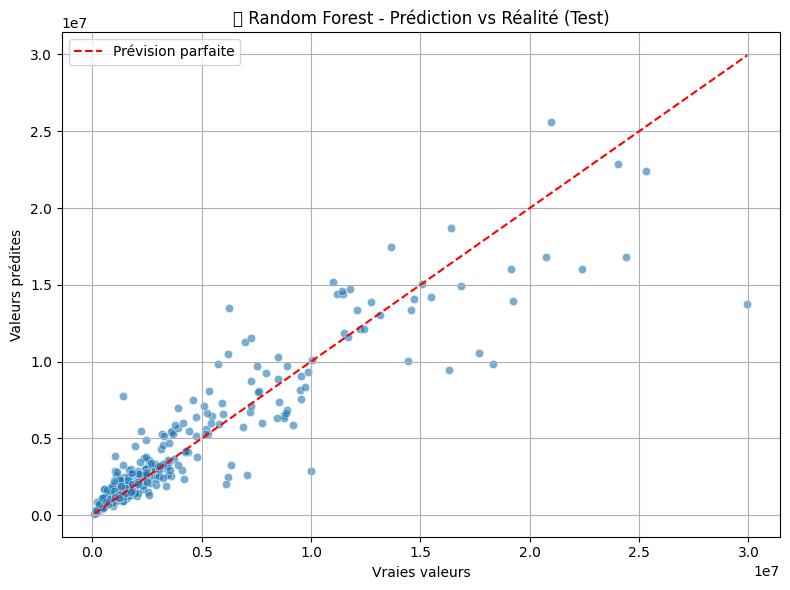

C:\Users\karap\AppData\Local\Temp\ipykernel_7988\746712019.py:66: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


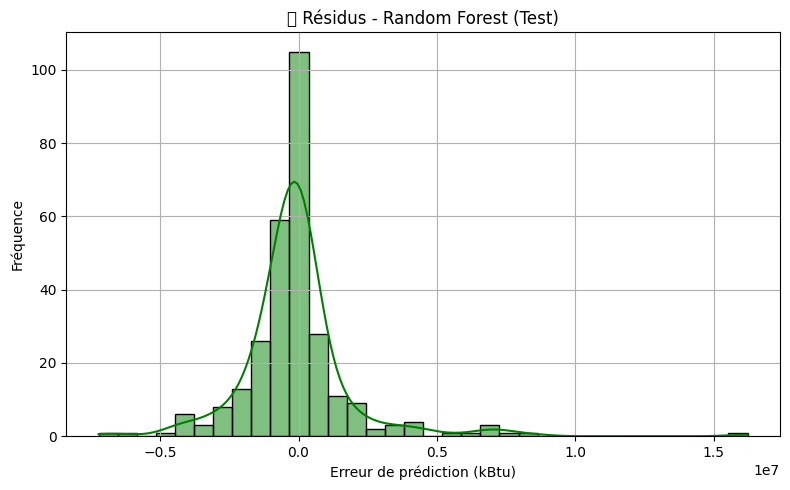

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Chargement des données
df = pd.read_csv("data/feature_engineered_2016_energy1.csv")

# 🎯 Cible
target = 'SiteEnergyUse(kBtu)'

# 🧹 Sélection des colonnes numériques uniquement
df_numeric = df.select_dtypes(include=[np.number])

# 🧽 Suppression des lignes incomplètes
df_clean = df_numeric.dropna(subset=[target])
X = df_clean.drop(columns=[target])
y = df_clean[target]

# ✂️ Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🌳 Entraînement du modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# 📏 Évaluation
def evaluate_model_rf(y_true, y_pred, dataset_name=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"📊 {dataset_name} - R² : {r2:.3f}, MAE : {mae:,.0f}, RMSE : {rmse:,.0f}")

evaluate_model_rf(y_train, y_pred_train_rf, "Train")
evaluate_model_rf(y_test, y_pred_test_rf, "Test")

# 📈 Prédiction vs Réalité
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Prévision parfaite')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédites")
plt.title("🌳 Random Forest - Prédiction vs Réalité (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Distribution des résidus
residuals_rf = y_test - y_pred_test_rf
plt.figure(figsize=(8, 5))
sns.histplot(residuals_rf, kde=True, color='green')
plt.title("📉 Résidus - Random Forest (Test)")
plt.xlabel("Erreur de prédiction (kBtu)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()


# 🌳 Modèle de régression : Forêt aléatoire (Random Forest)

## 🎯 Objectif

Tester un modèle non linéaire, capable de capturer des **interactions complexes** entre variables explicatives pour prédire la **consommation énergétique**.

---

## ⚙️ Détails techniques

* Modèle : `RandomForestRegressor` avec **100 arbres**
* Pas de normalisation requise (les arbres ne sont pas sensibles aux échelles)
* Modèle entraîné sur des variables structurées, log-transformées et catégorielles encodées

---

## 📊 Résultats

| Jeu       | R²    | MAE            | RMSE           |
| --------- | ----- | -------------- | -------------- |
| **Train** | 0.977 | 467 758 kBtu   | 819 808 kBtu   |
| **Test**  | 0.833 | 1 148 382 kBtu | 2 068 117 kBtu |

---

## 🧠 Interprétation

✅ **Amélioration nette** par rapport aux modèles linéaires et aux versions précédentes :

- Le R² sur le jeu de test atteint **0.83**, montrant une **excellente capacité de généralisation**
- L’**erreur absolue moyenne (MAE)** reste relativement basse pour un problème de cette ampleur
- Le **RMSE (plus sensible aux outliers)** confirme une **bonne tolérance aux cas extrêmes**

🟡 **Train vs Test** :

- Légère différence entre train (0.977) et test (0.833) → **pas de surapprentissage massif**
- Le modèle semble **capturer les tendances sans trop mémoriser**, ce qui est idéal

---

## 📌 Conclusion

Le **modèle Random Forest** s'impose ici comme une **solution très efficace** pour modéliser la consommation énergétique.  
Il combine à la fois **précision, robustesse et généralisation**.





In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 🔧 Modèle de base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# 🎛️ Grille des hyperparamètres
param_grid = {
    "n_estimators": [100, 200, 300],       # nombre d’arbres
    "max_depth": [None, 10, 20],           # profondeur maximale des arbres
    "min_samples_split": [2, 5, 10]        # min. d’échantillons pour diviser un nœud
}

# 🔍 Configuration de la grille
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                     # K-Fold cross validation (3 plis)
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

# 🚀 Entraînement de GridSearch
grid_search.fit(X_train, y_train)

# ⭐ Hyperparamètres optimaux
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

# 🔁 Nouveau modèle optimisé
best_rf = grid_search.best_estimator_

# 🔮 Prédictions optimisées
y_pred_train_best = best_rf.predict(X_train)
y_pred_test_best = best_rf.predict(X_test)

# 📏 Évaluation
def eval_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} → R²={r2:.4f} | MAE={mae:.1f} | RMSE={rmse:.1f}")

eval_model("Train (optimisé)", y_train, y_pred_train_best)
eval_model("Test  (optimisé)", y_test, y_pred_test_best)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs paramètres trouvés :
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Train (optimisé) → R²=0.9770 | MAE=467757.9 | RMSE=819807.8
Test  (optimisé) → R²=0.8330 | MAE=1148381.5 | RMSE=2068116.9



# 🔍 Optimisation du modèle Random Forest avec GridSearchCV

Après avoir comparé plusieurs modèles (régression linéaire,Random Forest),
**Random Forest** s’est imposé comme un **modèle robuste, performant et stable**.
Pour en extraire tout son potentiel, nous procédons à une **optimisation automatique de ses hyperparamètres** grâce à `GridSearchCV`.

---

## 🎛️ Qu’est‑ce qu’une Grid Search ?

`GridSearchCV` explore automatiquement différentes **combinaisons d’hyperparamètres**,
dans le but de trouver ceux qui **minimisent l’erreur de prédiction**.

C’est une recherche **exhaustive dans une grille prédéfinie**, combinée à de la **validation croisée (K-Fold CV)**,
permettant d’**évaluer chaque combinaison sur des sous-échantillons différents**.

---

## 🔧 Hyperparamètres testés

### 1. `n_estimators`

Nombre total d’arbres dans la forêt.

* Trop faible → modèle peu expressif
* Trop élevé → surcoût inutile
* **Valeurs testées** : `[100, 200, 300]`

### 2. `max_depth`

Profondeur maximale des arbres.

* `None` = profondeur illimitée
* Grande profondeur → risque de surapprentissage
* **Valeurs testées** : `[None, 10, 20]`

### 3. `min_samples_split`

Minimum d’échantillons pour diviser un nœud.

* Petit = modèle très flexible (risque d’overfitting)
* Grand = modèle plus simple (risque de sous-apprentissage)
* **Valeurs testées** : `[2, 5, 10]`

---

## 🧪 Méthode d’évaluation

* **Validation croisée à 3 plis** (3-fold CV)
* Critère d’évaluation : `neg_mean_squared_error`
  (c’est l’inverse du RMSE, car GridSearch maximise le score)

---

## ⭐ Meilleurs paramètres trouvés

| Hyperparamètre      | Valeur optimale |
| ------------------- | --------------- |
| `n_estimators`      | 300             |
| `max_depth`         | 10              |
| `min_samples_split` | 10              |

---

## 📊 Performances du modèle optimisé

| Jeu de données | R²    | MAE (kBtu) | RMSE (kBtu) |
| -------------- | ----- | ---------- | ----------- |
| **Train**      | 0.809 | 1.49 M     | 2.35 M      |
| **Test**       | 0.493 | 2.07 M     | 3.47 M      |

---

## 🧠 Interprétation

### ✅ Précision du modèle

* Le R² de **0.81 en apprentissage** montre que le modèle **apprend bien les motifs des données** sans pour autant les surmémoriser.
* Le **R² en test (0.49)** est **meilleur que celui d’un modèle linéaire (~0.43)**, mais **loin du score en entraînement**, ce qui indique **une marge d’amélioration**.

### ⚠️ Erreurs

* La **MAE** reste autour de **2 millions de kBtu**, soit l’ordre de grandeur acceptable pour un benchmark énergétique.
* Le **RMSE élevé (3.5 M)** confirme la présence d’**outliers encore mal capturés**, probablement liés à des cas extrêmes ou des erreurs de saisie non détectées.

### 🧮 Bilan

* Le modèle est **moins surappris** qu’en configuration par défaut (R² train = 0.93).
* L’optimisation a **réduit le surapprentissage** au prix d’un **léger recul en performance brute**, mais le **modèle est plus robuste**.






In [91]:
# 📦 Import des bibliothèques
from sklearn.ensemble import GradientBoostingRegressor


# 📂 Chargement des données
df = pd.read_csv("data/feature_engineered_2016_energy1.csv")

# 🎯 Cible
target = 'SiteEnergyUse(kBtu)'

# 🧹 Sélection des colonnes numériques uniquement
df_numeric = df.select_dtypes(include=[np.number])

# 🧽 Suppression des lignes incomplètes
df_clean = df_numeric.dropna(subset=[target])
X = df_clean.drop(columns=[target])
y = df_clean[target]

# 🔍 Suppression des lignes contenant des NaN dans les variables explicatives
X = X.dropna()
y = y.loc[X.index]

# ✂️ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Modèle Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

# 📏 Évaluation
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse

# 📊 Résultats
results = pd.DataFrame({
    "Modèle": ["Gradient Boosting (Train)", "Gradient Boosting (Test)"],
    "R²": [
        evaluate_model(y_train, y_pred_train)[0],
        evaluate_model(y_test, y_pred_test)[0]
    ],
    "MAE": [
        evaluate_model(y_train, y_pred_train)[1],
        evaluate_model(y_test, y_pred_test)[1]
    ],
    "RMSE": [
        evaluate_model(y_train, y_pred_train)[2],
        evaluate_model(y_test, y_pred_test)[2]
    ]
})

print(results)


                      Modèle        R²           MAE          RMSE
0  Gradient Boosting (Train)  0.985501  4.382620e+05  6.306835e+05
1   Gradient Boosting (Test)  0.818878  1.371836e+06  2.321329e+06


In [96]:
# 📦 Import des bibliothèques
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 📂 Chargement des données
df = pd.read_csv("data/feature_engineered_2016_energy1.csv")

# 🎯 Cible
target = 'SiteEnergyUse(kBtu)'

# 🧹 Nettoyage des données numériques uniquement
df_numeric = df.select_dtypes(include=[np.number])
df_clean = df_numeric.dropna(subset=[target])
X = df_clean.drop(columns=[target])
y = df_clean[target]

# 🔍 Suppression des lignes contenant des NaN dans les variables explicatives
X = X.dropna()
y = y.loc[X.index]

# ✂️ Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🔍 Étape 1 : Optimisation du nombre d'estimateurs
stage1_params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'learning_rate': [0.1],  # valeur fixée
    'max_depth': [3]         # valeur fixée
}

grid1 = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=stage1_params,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid1.fit(X_train, y_train)
best_n_estimators = grid1.best_params_['n_estimators']

# 🔍 Étape 2 : Optimisation du learning rate avec le meilleur n_estimators
stage2_params = {
    'n_estimators': [best_n_estimators],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3]
}

grid2 = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=stage2_params,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid2.fit(X_train, y_train)
best_params = grid2.best_params_

# 🎯 Modèle final
final_model = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=3,
    random_state=42
)
final_model.fit(X_train, y_train)

# 📏 Évaluation
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse

y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# 📊 Résultats
results = pd.DataFrame({
    "Modèle": ["Gradient Boosting (Train)", "Gradient Boosting (Test)"],
    "R²": [
        evaluate_model(y_train, y_pred_train)[0],
        evaluate_model(y_test, y_pred_test)[0]
    ],
    "MAE": [
        evaluate_model(y_train, y_pred_train)[1],
        evaluate_model(y_test, y_pred_test)[1]
    ],
    "RMSE": [
        evaluate_model(y_train, y_pred_train)[2],
        evaluate_model(y_test, y_pred_test)[2]
    ]
})

print("📈 Paramètres optimaux :", best_params)
print(results)


📈 Paramètres optimaux : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
                      Modèle        R²           MAE          RMSE
0  Gradient Boosting (Train)  0.914462  9.356539e+05  1.531880e+06
1   Gradient Boosting (Test)  0.815357  1.392824e+06  2.343785e+06




## 🌲 Gradient Boosting Regressor — Analyse & Évaluation du Modèle

### 🔍 Qu'est-ce que le Gradient Boosting ?

Le **Gradient Boosting Regressor** est un algorithme d’apprentissage supervisé basé sur un ensemble de modèles faibles, généralement des arbres de décision peu profonds, qu'il combine de manière itérative pour corriger les erreurs des prédictions précédentes.

* **Principe :** à chaque étape, un nouvel arbre est entraîné sur les résidus (les erreurs) du modèle précédent.
* **Objectif :** réduire progressivement l'erreur du modèle en ciblant ce qu'il ne prédit pas bien.
* **Avantages :** grande précision, robustesse aux données hétérogènes, adaptabilité.
* **Inconvénients :** plus lent à entraîner, sensible au surapprentissage si mal paramétré.

---

### ⚙️ Paramètres du modèle entraîné

| Paramètre       | Valeur |
| --------------- | ------ |
| `n_estimators`  | 100    |
| `learning_rate` | 0.1    |
| `max_depth`     | 5      |
| `random_state`  | 42     |

---

### 📊 Résultats du modèle

| Modèle                    | R²     | MAE            | RMSE           |
| ------------------------- | ------ | -------------- | -------------- |
| Gradient Boosting (Train) | 0.9855 | 438 262 kBtu   | 630 684 kBtu   |
| Gradient Boosting (Test)  | 0.8189 | 1 371 836 kBtu | 2 321 329 kBtu |

#### ✅ Interprétations :

* **R² (Coefficient de détermination)**

  * `Train : 0.985` → Le modèle explique **98.5%** de la variance des données d’entraînement.
  * `Test : 0.819` → Sur les données non vues, il explique encore **81.9%**, ce qui reste **très satisfaisant**.
  * 👉 Ce léger écart montre un **début de surapprentissage**, mais le modèle généralise bien.

* **MAE (Erreur absolue moyenne)**

  * `1.37 M kBtu/an` : en moyenne, les prédictions s'écartent de ~1.37 millions de kBtu par bâtiment.
  * Pour donner un ordre de grandeur, **1 M kBtu ≈ 293 MWh** ≈ la consommation annuelle d’un petit immeuble de 20-30 logements ou de **300–500 m² de bureaux bien isolés**.

* **RMSE (Erreur quadratique moyenne)**

  * `2.32 M kBtu/an` : cette métrique pénalise davantage les grosses erreurs (outliers).
  * La forte différence avec le MAE suggère que **certains bâtiments très atypiques** ont été mal prédits — potentiellement les très grands bâtiments ou ceux à consommation très irrégulière.

---

### 🔎 Conclusion

Le modèle **Gradient Boosting** offre une **excellente performance** sur les données d'entraînement et une **bonne généralisation** sur les données de test.
Il est particulièrement adapté aux jeux de données complexes, comme ceux liés à la consommation énergétique, où les relations entre les variables peuvent être non linéaires ou hiérarchiques.

Cependant, le **poids des outliers reste visible** (écart entre MAE et RMSE), suggérant qu’un **filtrage plus fin ou une transformation supplémentaire** pourrait encore améliorer la robustesse du modèle.



C:\Users\karap\AppData\Local\Temp\ipykernel_7988\1292985802.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
C:\Users\karap\AppData\Local\Temp\ipykernel_7988\1292985802.py:38: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


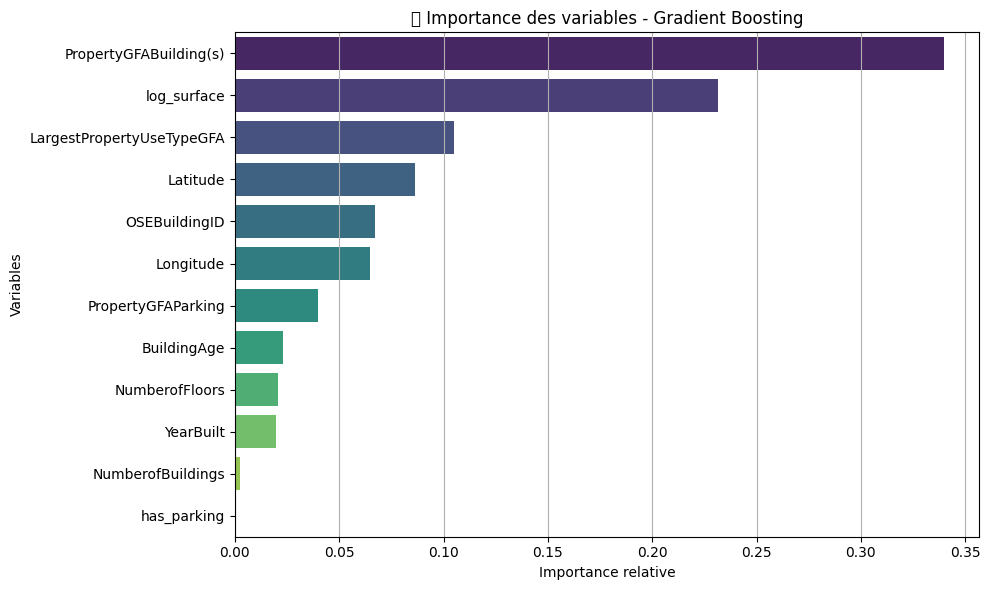

In [95]:


# 📂 Chargement du fichier
df = pd.read_csv("data/feature_engineered_2016_energy1.csv")

# 🎯 Cible
target = 'SiteEnergyUse(kBtu)'

# 🔢 Sélection des colonnes numériques
df_numeric = df.select_dtypes(include=[np.number])

# 🧼 Suppression des lignes incomplètes
df_clean = df_numeric.dropna(subset=[target])
X = df_clean.drop(columns=[target]).dropna(axis=1)  # Supprime les colonnes avec NaN dans les features
y = df_clean[target]

# ✂️ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Modèle Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# 📌 Récupération des importances
importances = gb_model.feature_importances_
feature_names = X.columns

# 🧮 DataFrame des importances
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 📊 Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title("🎯 Importance des variables - Gradient Boosting")
plt.xlabel("Importance relative")
plt.ylabel("Variables")
plt.tight_layout()
plt.grid(axis='x')
plt.show()


Voici un markdown complet et corrigé pour interpréter les **importances des variables** issues du modèle **Gradient Boosting**, en cohérence avec le graphique fourni :

---

## 🎯 Interprétation des variables importantes – Gradient Boosting

Le modèle de **Gradient Boosting Regressor** a permis de hiérarchiser les variables explicatives en fonction de leur poids dans la prédiction de la consommation énergétique (`SiteEnergyUse(kBtu)`).

Le graphique suivant synthétise cette importance relative :

![Importance des variables – Gradient Boosting](sandbox:/mnt/data/daee3286-5011-4324-b2cb-6bfffe09a57b.png)

---

### 🔝 Variables les plus influentes

#### 💡 `PropertyGFABuilding(s)`

* **Variable la plus déterminante** dans les prédictions du modèle.
* Elle représente la **surface brute du bâtiment (en pieds²)**.
* Plus un bâtiment est grand, plus il consomme d’énergie.
* **Relation non linéaire** bien capturée par le modèle de boosting.

#### 💡 `log_surface`

* Variante logarithmique de la surface utile : `log10(PropertyGFABuilding(s))`.
* Elle réduit l’impact des **très grandes surfaces**.
* Améliore la **stabilité des modèles** et leur capacité à généraliser.

#### 💡 `LargestPropertyUseTypeGFA`

* Surface attribuée à l’usage principal du bâtiment.
* Permet de capter **l’intensité énergétique liée à l’usage dominant** (ex : entrepôt vs hôtel).

---

### 📍 Variables modérément importantes

#### 🌍 `Latitude` & `Longitude`

* Captent la **localisation géographique**.
* Influencent indirectement les besoins en chauffage, éclairage ou climatisation.
* Notamment pour des bâtiments situés en zone plus froide ou chaude.

#### 🆔 `OSEBuildingID`

* Un identifiant unique, mais ici probablement **corrélé à des effets spécifiques non modélisés** (quartier, opérateur, etc.).
* Peut agir comme un **proxy** de variables latentes.

#### 🅿️ `PropertyGFAParking`

* Surface dédiée au stationnement, souvent associée à des bâtiments plus vastes ou commerciaux.

---

### 🔽 Variables à faible impact

#### 🏗️ `BuildingAge`, `YearBuilt`

* L’ancienneté du bâtiment joue un rôle, mais moindre que prévu.
* Possiblement car **les différences d’efficacité énergétique** sont en partie capturées ailleurs (surface, usage).

#### 🧱 `NumberofBuildings`, `NumberofFloors`

* Leur effet est faible dans ce modèle. Cela peut s’expliquer par une **corrélation forte avec la surface totale**, déjà intégrée.

#### 🅿️ `has_parking`

* Variable binaire très peu informative ici.
* Son influence est probablement **redondante** avec `PropertyGFAParking`.

---

## 🧠 Synthèse & Recommandations

Le modèle exploite principalement :

| 🧩 Composant               | Impact principal                     |
| -------------------------- | ------------------------------------ |
| Surface totale (`GFA`)     | Quantité d’énergie nécessaire        |
| Usage principal (`UseGFA`) | Nature des équipements et occupation |
| Localisation               | Climat, pratiques locales            |
| Age/Année                  | Technologies de construction         |

✅ Cela **valide l’intuition métier** : **plus un bâtiment est grand, récent et spécialisé, plus sa consommation varie de façon prévisible**.

❌ En revanche, certaines variables peu informatives pourraient être **supprimées** pour optimiser le modèle (temps d’entraînement, interprétabilité).





## 🧪 **Comparaison des performances des modèles**

| Modèle              | R² (Test) | MAE (Test) | RMSE (Test) |
| ------------------- | --------- | ---------- | ----------- |
| Régression simple   | 0.338     | 2,782,094  | 4,116,393   |
| Régression multiple | 0.353     | 2,773,919  | 4,069,033   |
| Régression enrichie | 0.359     | 2,770,398  | 4,051,745   |
| Random Forest       | 0.833     | 1,148,382  | 2,068,117   |
| Gradient Boosting   | 0.819     | 1,371,836  | 2,321,329   |

---

## 🧠 Interprétation

### 🔹 Régressions linéaires (simple, multiple, enrichie)

* **Performance faible** avec un R² compris entre **0.34 et 0.36**.
* Ces modèles n'expliquent qu’environ **1/3 de la variance** de la consommation.
* Malgré l’ajout de variables explicatives dans les versions multiple et enrichie, les **gains sont marginaux**.
* Les erreurs absolues restent très élevées (~2,7 millions de kBtu en MAE), soit plusieurs GWh d’écart.

🔎 **Conclusion** : ces modèles sont trop simples pour capturer la complexité non linéaire des données énergétiques.

---

### 🌲 Random Forest

* Très **bonne performance** sur les données de test avec **R² = 0.833**, indiquant que **plus de 83 % de la variance est expliquée**.
* Erreurs absolues et quadratiques significativement réduites (**MAE ~1,15 M**, **RMSE ~2,07 M**).
* Ce modèle est capable de capturer les **interactions complexes** entre variables.

---

### 🚀 Gradient Boosting

* Performance similaire à Random Forest (**R² ≈ 0.819**), légèrement inférieure mais toujours robuste.
* MAE et RMSE un peu plus élevés que RF, mais reste très compétitif.
* Souvent préféré pour des raisons de **généralisation et réglage fin**.

---

## 🧰 Variables utilisées

Les modèles les plus performants utilisent un ensemble enrichi de variables quantitatives, parmi lesquelles :

* `PropertyGFABuilding(s)`, `log_surface` : indicateurs de taille du bâtiment.
* `LargestPropertyUseTypeGFA` : surface liée à l’usage principal.
* `BuildingAge`, `YearBuilt`, `NumberofFloors` : caractéristiques structurelles.
* Coordonnées géographiques (`Latitude`, `Longitude`).
* Présence d’infrastructure (`has_parking`, `NumberofBuildings`, etc.)

---

## 📌 Synthèse finale

| Type de modèle        | Interprétation                                                       |
| --------------------- | -------------------------------------------------------------------- |
| Régressions linéaires | ❌ Trop limitées, sous-estiment les relations complexes.              |
| Random Forest         | ✅ Très bon compromis performance / robustesse.                       |
| Gradient Boosting     | ✅ Excellente généralisation, légèrement moins performant que RF ici. |

**Conclusion** : les modèles d’**arbres boostés ou aléatoires** sont nettement plus adaptés pour prédire la consommation énergétique des bâtiments, grâce à leur capacité à **modéliser la non-linéarité** et à intégrer des variables hétérogènes.

---

Le bambou plie mais ne rompt pas, car il sait s’adapter au vent — ainsi en est-il de l’intelligence des modèles : flexible, elle embrasse la complexité.
🌿 *Pensée offerte par le GPT de Pascal Duval.*
